In [18]:
import numpy as np
from numpy.random import binomial, normal
import scipy.stats as st
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt

def data(mu, sigmas, phi, n):
    """
    Generates samples from Mixture of 2 Gaussian Distributions
    """
    y = []
    for i in range(n):
        ind = binomial(1, phi, 1)
        if ind == 1:
            y.append(normal(mu[0], sigmas[0], 1))
        else:
            y.append(normal(mu[1], sigmas[1], 1))
    return np.array(y)

def mixture_log_lik(x, mu, sigma, phi):
    """
    Calculates Log Likelihood for Mixture of 2 Gaussians
    """
    lik = phi * norm.pdf(x, mu[0], sigma[0]) + (1-phi) * norm.pdf(x, mu[1], sigma[1])
    return np.log(lik).sum()


def pgauss(x, y):
    """
    Returns Log-Likelihood for Multivariate Normal
    """
    return st.multivariate_normal.logpdf([x, y], mean=mus, cov=sigmas)


def metropolis_hastings(p, data, iter=1000, burn_in=200):
    mu = [0., 1.] 
    sigmas = [1., 1.]
    phi = .5
    samples = np.zeros((iter, 5))

    for i in range(iter):
        # Update mu values
        mu1, mu2 = np.array(mu) + normal(0,.1,size=2)
        alpha = min(1, np.exp(p(data, [mu1, mu2], sigmas, phi) - p(data, mu, sigmas, phi)))
        if np.random.rand() < alpha:
            mu = [mu1, mu2]
        
        # Update Sigma values
        sigma1, sigma2 = np.array(sigmas) + normal(0,.1,size = 2)
        alpha = min(1, np.exp(p(data, mu, [sigma1, sigma2], phi) - p(data, mu, sigmas, phi)))
        if np.random.rand() < alpha:
            sigmas = [sigma1, sigma2]
        
        # Update Phi values
        phi_1 = phi + normal(0,.05,size = 1)
        alpha = min(1, np.exp(p(data, mu, sigmas, phi_1) - p(data, mu, sigmas, phi)))
        if np.random.rand() < alpha:
            phi = phi_1
        
        samples[i,0:2] = np.array(mu)
        samples[i,2:4] = np.array(sigmas)
        samples[i,4] = phi

    return samples[burn_in:]


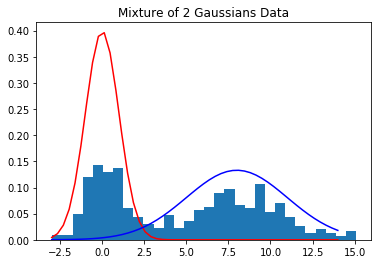

In [22]:
# Set Starting Parameters
mu = [0, 8]
sigmas = [1, 3]
phi = .4
n = 500
y = data(mu=mu, sigmas=sigmas, phi=phi, n=n)
x = np.linspace(-3,14)

# Create Plot of Data 
plt.hist(y, 30, normed=True)
plt.plot(x, norm(mu[0], sigmas[0]).pdf(x), color="red")
plt.plot(x, norm(mu[1], sigmas[1]).pdf(x), color="blue")
plt.title("Mixture of 2 Gaussians Data")
plt.show()

In [23]:
# Run the algorithm and extract the parameter values by taking means
trace = metropolis_hastings(mixture_log_lik, y, iter = 2000, burn_in=1000)
mu1 = np.mean(trace[:,0])
mu2 = np.mean(trace[:,1])
sigma1 = np.mean(trace[:,2])
sigma2 = np.mean(trace[:,3])
phi = np.mean(trace[:,4])

print(f"Phi: {phi}\nmu1: {mu1}\nmu2: {mu2}\nsigma1: {sigma1}\nsigma2: {sigma2}")

Phi: 0.4099810851087839
mu1: 0.15250007323744103
mu2: 7.870996468321337
sigma1: 1.0659509080922067
sigma2: 2.9435645489094697


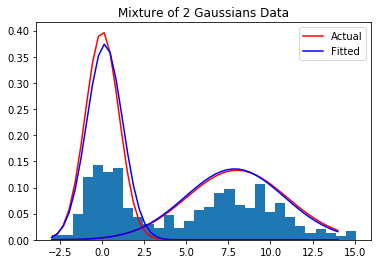

In [24]:
# Plotting Fitted Params
plt.hist(y, 30, normed=True)
plt.plot(x, norm(mu[0], sigmas[0]).pdf(x), color="red", label="Actual")
plt.plot(x, norm(mu[1], sigmas[1]).pdf(x), color="red")
plt.plot(x, norm(mu1, sigma1).pdf(x), color="blue", label="Fitted")
plt.plot(x, norm(mu2, sigma2).pdf(x), color="blue")
plt.title("Mixture of 2 Gaussians Data")
plt.legend(loc="upper right")
plt.show()

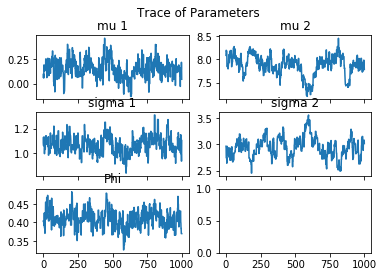

In [25]:
# Plotting Trace of Paameters Through the Markov Chain
fig, axs = plt.subplots(3,2, sharex=True)
x = range(trace.shape[0])
axs[0,0].plot(x, trace[:,0])
axs[0,0].set_title("mu 1")
axs[0,1].plot(x, trace[:,1])
axs[0,1].set_title("mu 2")
axs[1,0].plot(x, trace[:,2])
axs[1,0].set_title("sigma 1")
axs[1,1].plot(x, trace[:,3])
axs[1,1].set_title("sigma 2")
axs[2,0].plot(x, trace[:,4])
axs[2,0].set_title("Phi")
fig.suptitle("Trace of Parameters")
fig.show()